In [11]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [12]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../Projet_1_data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

In [37]:
from Implementations import*

### First trial

In [16]:
y, tX, ids, tX_mean, tX_std = preprocess_data(y, tX, ids, mean=None, std=None, param=None)

In [25]:
k_fold = 2
model = 'ridge_regression'
degrees = np.arange(2,4,1)
lambdas = np.logspace(-6,0,3)
accs_tr, accs_te = params_optimization(y, tX, k_fold, model, degrees, lambdas = lambdas, params = None, seed = 1)

Starting cross-validation 1/2 for ridge_regression, extended feature of degree 2 and arguments : {'lambda': 1e-06}
Starting cross-validation 2/2 for ridge_regression, extended feature of degree 2 and arguments : {'lambda': 1e-06}
Starting cross-validation 1/2 for ridge_regression, extended feature of degree 2 and arguments : {'lambda': 0.001}
Starting cross-validation 2/2 for ridge_regression, extended feature of degree 2 and arguments : {'lambda': 0.001}
Starting cross-validation 1/2 for ridge_regression, extended feature of degree 2 and arguments : {'lambda': 1.0}
Starting cross-validation 2/2 for ridge_regression, extended feature of degree 2 and arguments : {'lambda': 1.0}
Starting cross-validation 1/2 for ridge_regression, extended feature of degree 3 and arguments : {'lambda': 1e-06}
Starting cross-validation 2/2 for ridge_regression, extended feature of degree 3 and arguments : {'lambda': 1e-06}
Starting cross-validation 1/2 for ridge_regression, extended feature of degree 3 and

Accuracy rrays should feature 2 degrees (rows), 3 lambdas (columns)

In [32]:
print(np.array(accs_tr).shape)
print(np.array(accs_te).shape)

(2, 3)
(2, 3)


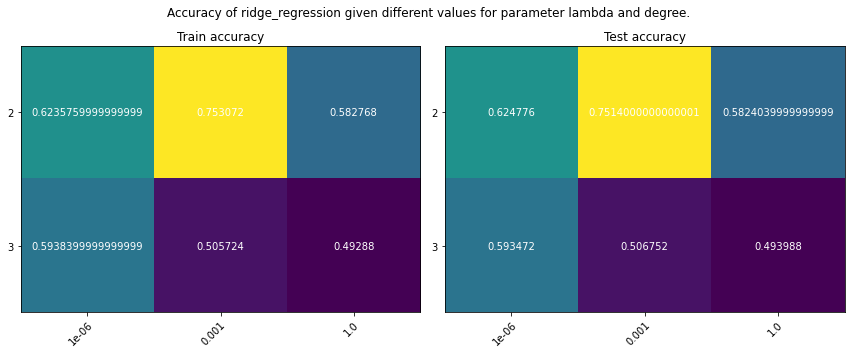

In [39]:
plot_heatmap(accs_tr, accs_te, degrees, lambdas, model)

## Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)